# W+Y in spectator di-quark model 
----

In [1]:
import sys,os
import numpy as np
import sympy as sp
from tools import save,load
from vector import VEC
from sympy.assumptions.assume import global_assumptions
from scipy.integrate import quad
import form
#from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
from sympy.utilities.lambdify import lambdify
import pylab as py
%matplotlib inline
sp.init_printing()
import warnings
warnings.filterwarnings('ignore')

## initialize vectors

In [2]:
xbj=sp.Symbol('x_{bj}')
xn=sp.Symbol('x_n')
Q=sp.Symbol('Q')
M=sp.Symbol('M')
mq=sp.Symbol('m_q')
ms=sp.Symbol('m_s')
nuk=sp.Symbol(r'\nu_k')
nukh=sp.Symbol(r'\nu_{\hat{k}}')
nukt=sp.Symbol(r'\nu_{\tilde{k}}')

In [3]:
P=VEC('P',[Q/xn/sp.sqrt(2),xn*M**2/Q/sp.sqrt(2),0,0])
q=VEC('q',[-Q/sp.sqrt(2),Q/sp.sqrt(2),0,0])
k=VEC('k')
kh=VEC(r'\hat{k}',[xbj*P.plus(),0,0,0])
kt=VEC(r'\tilde{k}',[xbj*P.plus(),None,None,None])

In [4]:
def to_massless(expr):
    return expr.subs(M,0).subs(mq,0).subs(ms,0).subs(xn,xbj)

In [5]:
data=form.run('sqamps.frm')

## run form to get sqamps

In [6]:
data=form.run('sqamps.frm')
def replace(exp):
    """
      this function replaces the sympy variables defined at form.py
      by the equivalent local expressions defined above 
      """
    exp=exp.subs('Pplus',P.plus())
    exp=exp.subs('Pminus',P.minus())
    exp=exp.subs('qplus',q.plus())
    exp=exp.subs('qminus',q.minus())
    exp=exp.subs('kplus',k.plus())
    exp=exp.subs('kminus',k.minus())
    exp=exp.subs('khplus',kh.plus())
    exp=exp.subs('khminus',kh.minus())
    exp=exp.subs('ktplus',kt.plus())
    exp=exp.subs('ktminus',kt.minus())
    exp=exp.subs('Q2',Q**2)
    exp=exp.subs('mq',mq)
    exp=exp.subs('ms',ms)
    exp=exp.subs('nuk',nuk)
    exp=exp.subs('nukh',nukh)
    exp=exp.subs('nukt',nukt)
    exp=exp.subs('sqrt2',sp.sqrt(2))
    exp=exp.subs('pi',sp.S.Pi)
    return exp
for r in data:
    data[r]=replace(data[r])

## Exact calculation
---

### construct delta functions

In [7]:
del1=(q+k)*(q+k)-mq**2
del1=del1.subs(k.perp2()**2,k.perp()**2-k.perp3()**2).simplify()
del2=(P-k)*(P-k)-ms**2
del2=del2.subs(k.perp2()**2,k.perp()**2-k.perp3()**2).simplify()

### jacobian

In [8]:
kplus=sp.solve(del1,k.plus())[0]
jac1=1/sp.diff(del1,k.plus())
jac2=1/sp.diff(del2.subs(k.plus(),kplus),k.minus()).simplify()
jac=sp.Abs(jac1*jac2)

### get solutions for $k_-$ and $k_+$

In [9]:
equation=del2.subs(k.plus(),kplus).factor()
equation*=(2*k.minus()+sp.sqrt(2)*Q)*Q*xn
equation=equation.factor()
poly=sp.poly(equation.simplify(),k.minus())
a=poly.coeffs()[0].simplify()
b=poly.coeffs()[1].simplify()
c=poly.coeffs()[2].simplify()
disc=b**2-4*a*c
# b_lim=to_massless(b).expand().simplify()
# disc_lim=to_massless(disc).expand().simplify().factor()
kminus1=(-b-sp.sqrt(disc))/(2*a)
kminus2=(-b+sp.sqrt(disc))/(2*a)

### get $k_T^{(\rm max)}$

In [10]:
W2=M**2+Q**2/xbj -Q**2
kTmax=sp.solve(sp.sqrt(W2)-sp.sqrt(mq**2+k.perp()**2)-sp.sqrt(ms**2+k.perp()**2),k.perp())[1]
lkTmax=sp.lambdify((xbj,Q,mq,ms,M),kTmax)

### build $\cal{F}_i$ 

In [11]:
T1=lambda part: -1/sp.S(2)*data['Pg*T%s'%part]+ 2*Q**2*xn**2/(M**2*xn**2+Q**2)**2*data['Ppp*T%s'%part]
T2=lambda part: 12*Q**4*xn**3*(Q**2-M**2*xn**2)/(Q**2+M**2*xn**2)**4*\
                (data['Ppp*T%s'%part] -(M**2*xn**2+Q**2)**2/(12*Q**2*xn**2)*data['Pg*T%s'%part])
prop=lambda part: data['prop%s'%part]
F1=lambda part:sp.Abs(jac)*T1(part)*prop(part)
F2=lambda part:sp.Abs(jac)*T2(part)*prop(part)
ljac=sp.lambdify((xn,Q,mq,ms,M,k.minus(),k.perp()),sp.Abs(jac))
lkplus=sp.lambdify((xn,Q,mq,ms,M,k.minus(),k.perp()),kplus)
lkminus1=sp.lambdify((xn,Q,mq,ms,M,k.perp()),kminus1)
lkminus2=sp.lambdify((xn,Q,mq,ms,M,k.perp()),kminus2)
lPminus=sp.lambdify((xn,Q,M),P.minus())
lPplus=sp.lambdify((xn,Q,M),P.plus())
lqminus=sp.lambdify((xn,Q,M),q.minus())
lqplus=sp.lambdify((xn,Q,M),q.plus())


lxn=sp.lambdify((xbj,M,Q),2*xbj/(1+sp.sqrt(1+4*xbj**2*M**2/Q**2)))

lnumAg=sp.lambdify((xn,Q,mq,ms,M,k.plus(),k.minus(),k.perp(),nuk),data['Pg*TA'])
lnumBg=sp.lambdify((xn,Q,mq,ms,M,k.plus(),k.minus(),k.perp(),nuk),data['Pg*TB'])
lnumCg=sp.lambdify((xn,Q,mq,ms,M,k.plus(),k.minus(),k.perp(),nuk),data['Pg*TC'])
lnumApp=sp.lambdify((xn,Q,mq,ms,M,k.plus(),k.minus(),k.perp(),nuk),data['Ppp*TA'])
lnumBpp=sp.lambdify((xn,Q,mq,ms,M,k.plus(),k.minus(),k.perp(),nuk),data['Ppp*TB'])
lnumCpp=sp.lambdify((xn,Q,mq,ms,M,k.plus(),k.minus(),k.perp(),nuk),data['Ppp*TC'])

lT1A=sp.lambdify((xn,Q,mq,ms,M,k.plus(),k.minus(),k.perp(),nuk),T1('A'))
lT1B=sp.lambdify((xn,Q,mq,ms,M,k.plus(),k.minus(),k.perp(),nuk),T1('B'))
lT1C=sp.lambdify((xn,Q,mq,ms,M,k.plus(),k.minus(),k.perp(),nuk),T1('C'))
lpropA=sp.lambdify((xn,Q,mq,ms,M,k.plus(),k.minus(),k.perp(),nuk),prop('A'))
lpropB=sp.lambdify((xn,Q,mq,ms,M,k.plus(),k.minus(),k.perp(),nuk),prop('B'))
lpropC=sp.lambdify((xn,Q,mq,ms,M,k.plus(),k.minus(),k.perp(),nuk),prop('C'))


lF1A=sp.lambdify((xn,Q,mq,ms,M,k.plus(),k.minus(),k.perp(),nuk),F1('A'))
lF1B=sp.lambdify((xn,Q,mq,ms,M,k.plus(),k.minus(),k.perp(),nuk),F1('B'))
lF1C=sp.lambdify((xn,Q,mq,ms,M,k.plus(),k.minus(),k.perp(),nuk),F1('C'))

lF2A=sp.lambdify((xn,Q,mq,ms,M,k.plus(),k.minus(),k.perp(),nuk),F2('A'))
lF2B=sp.lambdify((xn,Q,mq,ms,M,k.plus(),k.minus(),k.perp(),nuk),F2('B'))
lF2C=sp.lambdify((xn,Q,mq,ms,M,k.plus(),k.minus(),k.perp(),nuk),F2('C'))


def lnuk(xn,Q,mq,ms,M,kperp,sol):
    if sol==1: kminus=lkminus1(xn,Q,mq,ms,M,kperp)
    if sol==2: kminus=lkminus2(xn,Q,mq,ms,M,kperp)
    kplus=lkplus(xn,Q,mq,ms,M,kminus,kperp)
    k2=2*kplus*kminus-kperp**2
    return (-k2)**0.5

def lkfrap(xn,Q,mq,ms,M,kperp,sol):
    if sol==1:kminus=lkminus1(xn,Q,mq,ms,M,kperp)
    if sol==2:kminus=lkminus2(xn,Q,mq,ms,M,kperp)
    kplus=lkplus(xn,Q,mq,ms,M,kminus,kperp)
    qminus=lqminus(xn,Q,M)
    qplus=lqplus(xn,Q,M)
    return 1/sp.S(2)*sp.log(np.abs((kplus+qplus)/(kminus+qminus)))

def lPrap(xn,Q,M):
    return 1/sp.S(2)*sp.log(np.abs(lPplus(xn,Q,M)/lPminus(xn,Q,M)))

_lz=sp.lambdify((xn,Q,mq,ms,M,k.plus(),k.minus(),k.perp()),1+(P.plus()*k.minus()+P.minus()*k.plus())/(P.plus()*q.minus()+P.minus()*q.plus()))
def lz(xn,Q,mq,ms,M,kperp,sol):
    if sol==1:kminus=lkminus1(xn,Q,mq,ms,M,kperp)
    if sol==2:kminus=lkminus2(xn,Q,mq,ms,M,kperp)
    kplus=lkplus(xn,Q,mq,ms,M,kminus,kperp)
    return _lz(xn,Q,mq,ms,M,kplus,kminus,kperp)

def _lF1(xn,Q,mq,ms,M,kperp,graph,sol):
    if sol==1: kminus=lkminus1(xn,Q,mq,ms,M,kperp)
    if sol==2: kminus=lkminus2(xn,Q,mq,ms,M,kperp)
    kplus=lkplus(xn,Q,mq,ms,M,kminus,kperp)
    nuk=2*kplus*kminus-kperp**2
    if graph=='A':return lF1A(xn,Q,mq,ms,M,kplus,kminus,kperp,nuk)
    if graph=='B':return lF1B(xn,Q,mq,ms,M,kplus,kminus,kperp,nuk)
    if graph=='C':return lF1C(xn,Q,mq,ms,M,kplus,kminus,kperp,nuk)

def lF1_by_graph(xn,Q,mq,ms,M,kperp,graph):
    return _lF1(xn,Q,mq,ms,M,kperp,graph,1)\
          +_lF1(xn,Q,mq,ms,M,kperp,graph,2)

def lF1_by_sol(xn,Q,mq,ms,M,kperp,sol):
    return _lF1(xn,Q,mq,ms,M,kperp,'A',sol)\
          +_lF1(xn,Q,mq,ms,M,kperp,'B',sol)\
          +_lF1(xn,Q,mq,ms,M,kperp,'C',sol)

def lF1(xn,Q,mq,ms,M,kperp):
    return lF1_by_graph(xn,Q,mq,ms,M,kperp,'A')\
          +lF1_by_graph(xn,Q,mq,ms,M,kperp,'B')\
          +lF1_by_graph(xn,Q,mq,ms,M,kperp,'C')
        
def _lF2(xn,Q,mq,ms,M,kperp,graph,sol):
    if sol==1: kminus=lkminus1(xn,Q,mq,ms,M,kperp)
    if sol==2: kminus=lkminus2(xn,Q,mq,ms,M,kperp)
    kplus=lkplus(xn,Q,mq,ms,M,kminus,kperp)
    nuk=2*kplus*kminus-kperp**2
    if graph=='A':return lF2A(xn,Q,mq,ms,M,kplus,kminus,kperp,nuk)
    if graph=='B':return lF2B(xn,Q,mq,ms,M,kplus,kminus,kperp,nuk)
    if graph=='C':return lF2C(xn,Q,mq,ms,M,kplus,kminus,kperp,nuk)

def lF2_by_graph(xn,Q,mq,ms,M,kperp,graph):
    return _lF2(xn,Q,mq,ms,M,kperp,graph,1)\
          +_lF2(xn,Q,mq,ms,M,kperp,graph,2)

def lF2_by_sol(xn,Q,mq,ms,M,kperp,sol):
    return _lF2(xn,Q,mq,ms,M,kperp,'A',sol)\
          +_lF2(xn,Q,mq,ms,M,kperp,'B',sol)\
          +_lF2(xn,Q,mq,ms,M,kperp,'C',sol)

def lF2(xn,Q,mq,ms,M,kperp):
    return lF2_by_graph(xn,Q,mq,ms,M,kperp,'A')\
          +lF2_by_graph(xn,Q,mq,ms,M,kperp,'B')\
          +lF2_by_graph(xn,Q,mq,ms,M,kperp,'C')

## W approximation
---

### hard part

In [12]:
H1= -1/sp.S(2)*data['Pg*hard'] + 2*Q**2*xn**2/(M**2*xn**2+Q**2)**2*data['Ppp*hard']
H2= 12*Q**4*xn**3*(Q**2-M**2*xn**2)/(Q**2+M**2*xn**2)**4*(data['Ppp*hard'] -(M**2*xn**2+Q**2)**2/(12*Q**2*xn**2)*data['Pg*hard'])
H1=H1.replace(M,0).replace(nukh,0).replace(xn,xbj)
H2=H2.replace(M,0).replace(nukh,0).replace(xn,xbj)

### soft part $f^{(1)}$

In [13]:
Wdel2=(P-kt)*(P-kt)-ms**2
Wdel2=Wdel2.replace(kt.perp2()**2,k.perp()**2-kt.perp3()**2).simplify()
Wjac=-1/sp.diff(Wdel2,kt.minus())
ktminus=sp.solve(Wdel2,kt.minus())[0].subs(kt.perp(),k.perp()).subs(xn,xbj)
Wnukt=(2*kt.plus()*ktminus-kt.perp()**2).subs(kt.perp(),k.perp()).factor().simplify()
num=sp.numer(data['f'].factor()).subs(nukt,Wnukt).subs(kt.minus(),ktminus).simplify()
den=sp.denom(data['f'].factor()).subs(nukt,Wnukt).subs(kt.minus(),ktminus).simplify()
f=(num/den*Wjac/(2*sp.pi)).subs(xn,xbj)

### build $W_i = T_{\rm TMD} {\cal F}_i$

In [14]:
W1=H1*f
W2=H2*f
lW1=sp.lambdify((xbj,Q,mq,ms,M,k.perp()),W1)
lW2=sp.lambdify((xbj,Q,mq,ms,M,k.perp()),W2)

## Large $k_T$ approximation  (FO)
---

In [15]:
lCjac=sp.lambdify((xbj,Q,k.minus(),k.perp()),to_massless(sp.Abs(jac)))
lCkplus=sp.lambdify((xbj,Q,k.minus(),k.perp()),to_massless(kplus))
lCkminus1=sp.lambdify((xbj,Q,k.perp()),to_massless(kminus1))
lCkminus2=sp.lambdify((xbj,Q,k.perp()),to_massless(kminus2))
lCF1A=sp.lambdify((xbj,Q,k.plus(),k.minus(),k.perp(),nuk),to_massless(F1('A')))
lCF1B=sp.lambdify((xbj,Q,k.plus(),k.minus(),k.perp(),nuk),to_massless(F1('B')))
lCF1C=sp.lambdify((xbj,Q,k.plus(),k.minus(),k.perp(),nuk),to_massless(F1('C')))
lCF2A=sp.lambdify((xbj,Q,k.plus(),k.minus(),k.perp(),nuk),to_massless(F2('A')))
lCF2B=sp.lambdify((xbj,Q,k.plus(),k.minus(),k.perp(),nuk),to_massless(F2('B')))
lCF2C=sp.lambdify((xbj,Q,k.plus(),k.minus(),k.perp(),nuk),to_massless(F2('C')))


def _lCF1(xbj,Q,kperp,graph,sol):
    if sol==1: kminus=lCkminus1(xbj,Q,kperp)
    if sol==2: kminus=lCkminus2(xbj,Q,kperp)
    kplus=lCkplus(xbj,Q,kminus,kperp)
    nuk=2*kplus*kminus-kperp**2
    if graph=='A':return lCF1A(xbj,Q,kplus,kminus,kperp,nuk)
    if graph=='B':return lCF1B(xbj,Q,kplus,kminus,kperp,nuk)
    if graph=='C':return lCF1C(xbj,Q,kplus,kminus,kperp,nuk)

def lCF1_by_graph(xbj,Q,kperp,graph):
    return _lCF1(xbj,Q,kperp,graph,1)\
          +_lCF1(xbj,Q,kperp,graph,2)

def lCF1_by_sol(xbj,Q,kperp,sol):
    return _lCF1(xbj,Q,kperp,'A',sol)\
          +_lCF1(xbj,Q,kperp,'B',sol)\
          +_lCF1(xbj,Q,kperp,'C',sol)

def lCF1(xbj,Q,kperp):
    return lCF1_by_graph(xbj,Q,kperp,'A')\
          +lCF1_by_graph(xbj,Q,kperp,'B')\
          +lCF1_by_graph(xbj,Q,kperp,'C')
        
def _lCF2(xbj,Q,kperp,graph,sol):
    if sol==1: kminus=lCkminus1(xbj,Q,kperp)
    if sol==2: kminus=lCkminus2(xbj,Q,kperp)
    kplus=lCkplus(xbj,Q,kminus,kperp)
    nuk=2*kplus*kminus-kperp**2
    if graph=='A':return lCF2A(xbj,Q,kplus,kminus,kperp,nuk)
    if graph=='B':return lCF2B(xbj,Q,kplus,kminus,kperp,nuk)
    if graph=='C':return lCF2C(xbj,Q,kplus,kminus,kperp,nuk)

def lCF2_by_graph(xbj,Q,kperp,graph):
    return _lCF2(xbj,Q,kperp,graph,1)\
          +_lCF2(xbj,Q,kperp,graph,2)

def lCF2_by_sol(xbj,Q,kperp,sol):
    return _lCF2(xbj,Q,kperp,'A',sol)\
          +_lCF2(xbj,Q,kperp,'B',sol)\
          +_lCF2(xbj,Q,kperp,'C',sol)

def lCF2(xbj,Q,kperp):
    return lCF2_by_graph(xbj,Q,kperp,'A')\
          +lCF2_by_graph(xbj,Q,kperp,'B')\
          +lCF2_by_graph(xbj,Q,kperp,'C')

## Asymptotic (ASY)
---

In [16]:
AW1=to_massless(W1)
AW2=to_massless(W2)
lAW1=sp.lambdify((xbj,Q,k.perp()),AW1)
lAW2=sp.lambdify((xbj,Q,k.perp()),AW2)

## Check against Teds library

In [17]:
def update(xbj=0.5,Q=2.,mq=0.5,ms=0.8,M=0.938,kT=0):
    xn=lxn(xbj,M,Q)

    c1g=-0.5
    c1pp=2*Q**2*xn**2/(M**2*xn**2+Q**2)**2
   
    c2pp=12*Q**4*xn**3*(Q**2-M**2*xn**2)/(Q**2+M**2*xn**2)**4
    c2g=-12*Q**4*xn**3*(Q**2-M**2*xn**2)/(Q**2+M**2*xn**2)**4*(M**2*xn**2+Q**2)**2/(12*Q**2*xn**2)



    kminus1=lkminus1(xn,Q,mq,ms,M,kT)
    kplus1=lkplus(xn,Q,mq,ms,M,kminus1,kT)
    kminus2=lkminus2(xn,Q,mq,ms,M,kT)
    kplus2=lkplus(xn,Q,mq,ms,M,kminus2,kT)
    jac1=ljac(xn,Q,mq,ms,M,kminus1,kT)
    jac2=ljac(xn,Q,mq,ms,M,kminus2,kT)

    nuk1=2*kplus1*kminus1-kT**2
    nuk2=2*kplus2*kminus2-kT**2
    
    numAg1=lnumAg(xn,Q,mq,ms,M,kplus1,kminus1,kT,nuk1)
    numBg1=lnumBg(xn,Q,mq,ms,M,kplus1,kminus1,kT,nuk1)
    numCg1=lnumCg(xn,Q,mq,ms,M,kplus1,kminus1,kT,nuk1)

    numAg2=lnumAg(xn,Q,mq,ms,M,kplus2,kminus2,kT,nuk2)
    numBg2=lnumBg(xn,Q,mq,ms,M,kplus2,kminus2,kT,nuk2)
    numCg2=lnumCg(xn,Q,mq,ms,M,kplus2,kminus2,kT,nuk2)

    numApp1=lnumApp(xn,Q,mq,ms,M,kplus1,kminus1,kT,nuk1)
    numBpp1=lnumBpp(xn,Q,mq,ms,M,kplus1,kminus1,kT,nuk1)
    numCpp1=lnumCpp(xn,Q,mq,ms,M,kplus1,kminus1,kT,nuk1)

    numApp2=lnumApp(xn,Q,mq,ms,M,kplus2,kminus2,kT,nuk2)
    numBpp2=lnumBpp(xn,Q,mq,ms,M,kplus2,kminus2,kT,nuk2)
    numCpp2=lnumCpp(xn,Q,mq,ms,M,kplus2,kminus2,kT,nuk2)
    
    propA1=lpropA(xn,Q,mq,ms,M,kplus1,kminus1,kT,nuk1)
    propB1=lpropB(xn,Q,mq,ms,M,kplus1,kminus1,kT,nuk1)    
    propC1=lpropC(xn,Q,mq,ms,M,kplus1,kminus1,kT,nuk1)

    propA2=lpropA(xn,Q,mq,ms,M,kplus2,kminus2,kT,nuk2)
    propB2=lpropB(xn,Q,mq,ms,M,kplus2,kminus2,kT,nuk2)    
    propC2=lpropC(xn,Q,mq,ms,M,kplus2,kminus2,kT,nuk2)
    
    F1g1=jac1*c1g*(propA1*numAg1+propB1*numBg1+propC1*numCg1)
    F1g2=jac2*c1g*(propA2*numAg2+propB2*numBg2+propC2*numCg2)
    F1pp1=jac1*c1pp*(propA1*numApp1+propB1*numBpp1+propC1*numCpp1)
    F1pp2=jac2*c1pp*(propA2*numApp2+propB2*numBpp2+propC2*numCpp2)

    F2g1=jac1*c2g*(propA1*numAg1+propB1*numBg1+propC1*numCg1)
    F2g2=jac2*c2g*(propA2*numAg2+propB2*numBg2+propC2*numCg2)
    F2pp1=jac1*c2pp*(propA1*numApp1+propB1*numBpp1+propC1*numCpp1)
    F2pp2=jac2*c2pp*(propA2*numApp2+propB2*numBpp2+propC2*numCpp2)

    F1g  =F1g1  + F1g2
    F1pp =F1pp1 + F1pp2
    F2g  =F2g1  + F2g2
    F2pp =F2pp1 + F2pp2
    FLg  =F2g - 2*xn*F1g 
    FLpp =F2pp - 2*xn*F1pp 

    F1   = F1g + F1pp
    F2   = F2g + F2pp
    FL   = FLg + FLpp
    
    print('FL=',FL)
    print('FLg=',FLg)
    print('FLpp=',FLpp)
    print('F2g=',F2g)
    print('2xnF1g=',2*xn*F1g)
    
#     exactppA1=jac1*(propA1*numApp1)
#     exactppB1=jac1*(propB1*numBpp1)
#     exactppC1=jac1*(propC1*numCpp1)

#     exactppA2=jac2*(propA2*numApp2)
#     exactppB2=jac2*(propB2*numBpp2)
#     exactppC2=jac2*(propC2*numCpp2)
    
    
#     F1A1=lF1A(xn,Q,mq,ms,M,kplus1,kminus1,kT,nuk1)
#     F1B1=lF1B(xn,Q,mq,ms,M,kplus1,kminus1,kT,nuk1)
#     F1C1=lF1C(xn,Q,mq,ms,M,kplus1,kminus1,kT,nuk1)

#     F1A2=lF1A(xn,Q,mq,ms,M,kplus2,kminus2,kT,nuk2)
#     F1B2=lF1B(xn,Q,mq,ms,M,kplus2,kminus2,kT,nuk2)
#     F1C2=lF1C(xn,Q,mq,ms,M,kplus2,kminus2,kT,nuk2)


#     print 'ksol1=',kplus1,kminus1,kT
#     print 'ksol2=',kplus2,kminus2,kT
#     print 'jac1=',jac1
#     print 'jac2=',jac2
#     print 'propA1',propA1
#     print 'propB1',propB1
#     print 'propC1',propC1
#     print 'propA2',propA2
#     print 'propB2',propB2
#     print 'propC2',propC2
#     print 'numAg1',numAg1
#     print 'numBg1',numBg1
#     print 'numCg1',numCg1
#     print 'numAg2',numAg2
#     print 'numBg2',numBg2
#     print 'numCg2',numCg2

#     print 'numApp1',numApp1
#     print 'numBpp1',numBpp1
#     print 'numCpp1',numCpp1
#     print 'numApp2',numApp2
#     print 'numBpp2',numBpp2
#     print 'numCpp2',numCpp2

    
#     print 'F1A1=',F1A1,jac1*propA1*(cg*numAg1+cpp*numApp1)
#     print 'F1B1=',F1B1,jac1*propB1*(cg*numBg1+cpp*numBpp1)
#     print 'F1C1=',F1C1,jac1*propC1*(cg*numCg1+cpp*numCpp1)
#     print 'F1A2=',F1A2,jac2*propA2*(cg*numAg2+cpp*numApp2)
#     print 'F1B2=',F1B2,jac2*propB2*(cg*numBg2+cpp*numBpp2)
#     print 'F1C2=',F1C2,jac2*propC2*(cg*numCg2+cpp*numCpp2)

#     print 'F1sol1=',lF1_by_sol(xn,Q,mq,ms,M,kT,1),F1A1+F1B1+F1C1
#     print 'F1sol2=',lF1_by_sol(xn,Q,mq,ms,M,kT,2),F1A2+F1B2+F1C2
    
#     print 'exactg1=',exactg1
#     print 'exactg2=',exactg2

#     print 'exactppA1=',exactppA1
#     print 'exactppB1=',exactppB1
#     print 'exactppC1=',exactppC1

#     print 'exactppA2=',exactppA2
#     print 'exactppB2=',exactppB2
#     print 'exactppC2=',exactppC2

#     print 'exactpp1=',exactpp1
#     print 'exactpp2=',exactpp2

    
interact(update,xbj=(0,1,0.01),Q=(1,1000,0.1),mq=(0,1,0.01),ms=(0,10,0.1),M=(0,10,0.1),kT=(0,100,0.1));

In [18]:
def update(xbj=0.5,Q=30.0,mq=0.3,ms=0.8,M=0.938,kT=3):
    xn=lxn(xbj,M,Q)
    exact=lF1(xn,Q,mq,ms,M,kT)
    FO=lCF1(xbj,Q,kT)
    W=lW1(xbj,Q,mq,ms,M,kT)
    ASY=lAW1(xbj,Q,kT)
    Y=FO-ASY
    approx=W+Y
    ratio=approx/exact
    print('exact        =',exact)
    print('W            =',W)
    print('ASY          =',ASY)
    print('FO           =',FO)
    print('approx       =',approx)
    print('approx/exact =',ratio)
interact(update,xbj=(0,1,0.01),Q=(1,1000,0.1),mq=(0,1,0.01),ms=(0,10,0.1),M=(0,10,0.1),kT=(0,100,0.1));

# Numerical studies 
---

## average kT and ms values

In [19]:
def update(xbj=0.2,Q=2.0,mq=0.3,ms=0.8,M=0.938,kT=0):
    
    xn=lxn(xbj,M,Q)
    kminus1=lkminus1(xn,Q,mq,ms,M,kT)
    kplus1=lkplus(xn,Q,mq,ms,M,kminus1,kT)
    k2=2*kminus1*kplus1-kT**2

    kTmax=lkTmax(xbj,Q,mq,ms,M)
    integrand=lambda kT: kT*lF1(lxn(xbj,M,Q),Q,mq,ms,M,kT)
    norm=quad(integrand,0,kTmax)[0]
    prob=lambda kT: kT*lF1(lxn(xbj,M,Q),Q,mq,ms,M,kT)/norm
    average_kT=quad(lambda kT: kT*prob(kT),0,kTmax)[0]  

    
    print('<kT>=',average_kT)
    print('k2=',k2)
interact(update,xbj=(0,1,0.01),Q=(1,100,0.1),mq=(0,1,0.01),ms=(0,10,0.1),M=(0,10,0.1),kT=(0,100,0.1));

In [20]:
def gen_kTarray(xbj,Q,mq,ms,M):
    _kTmax=lkTmax(xbj,Q,mq,ms,M)
    kT1=np.linspace(0,_kTmax*0.99999,300)
    kT2=np.linspace(_kTmax*0.99999,_kTmax-1e-10,200)
    return np.append(kT1,kT2)

### Study different contributions to exact ${\cal F}_1$

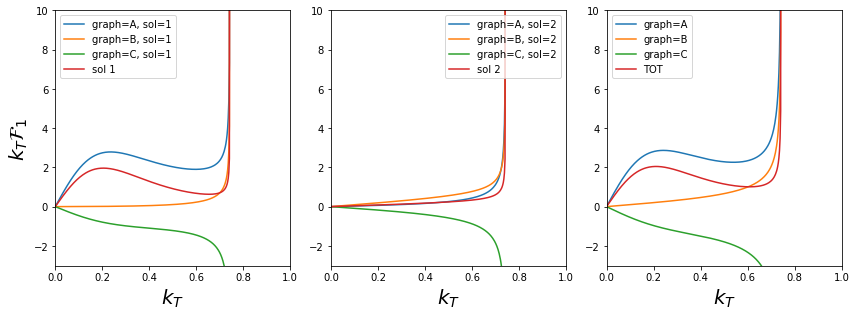

In [21]:
def update(xbj=0.6,Q=2.0,mq=0.5,ms=0.65,M=0.938,kTmax=1,ymin=-3,ymax=10):
    xn=lxn(xbj,M,Q)
    ncols,nrows=3,1
    fig = py.figure(figsize=(ncols*4,nrows*4.5))
    kT=gen_kTarray(xbj,Q,mq,ms,M)

    ax = fig.add_subplot(131)
    ax.plot(kT,[_kT*_lF1(xn,Q,mq,ms,M,_kT,'A',1) for _kT in kT],label='graph=A, sol=1')
    ax.plot(kT,[_kT*_lF1(xn,Q,mq,ms,M,_kT,'B',1) for _kT in kT],label='graph=B, sol=1')
    ax.plot(kT,[_kT*_lF1(xn,Q,mq,ms,M,_kT,'C',1) for _kT in kT],label='graph=C, sol=1')
    ax.plot(kT,[_kT*lF1_by_sol(xn,Q,mq,ms,M,_kT,1) for _kT in kT],label='sol 1')
    ax.legend()
    ax.set_ylim(ymin,ymax)
    ax.set_xlim(0,kTmax)
    ax.set_ylabel('$k_T {\cal F}_1$',size=20)
    ax.set_xlabel('$k_T$',size=20)

    ax = fig.add_subplot(132)
    ax.plot(kT,[_kT*_lF1(xn,Q,mq,ms,M,_kT,'A',2) for _kT in kT],label='graph=A, sol=2')
    ax.plot(kT,[_kT*_lF1(xn,Q,mq,ms,M,_kT,'B',2) for _kT in kT],label='graph=B, sol=2')
    ax.plot(kT,[_kT*_lF1(xn,Q,mq,ms,M,_kT,'C',2) for _kT in kT],label='graph=C, sol=2')
    ax.plot(kT,[_kT*lF1_by_sol(xn,Q,mq,ms,M,_kT,2) for _kT in kT],label='sol 2')
    ax.legend()
    ax.set_ylim(ymin,ymax)
    ax.set_xlim(0,kTmax)
    ax.set_xlabel('$k_T$',size=20)

    ax = fig.add_subplot(133)
    ax.plot(kT,[_kT*lF1_by_graph(xn,Q,mq,ms,M,_kT,'A') for _kT in kT],label='graph=A')
    ax.plot(kT,[_kT*lF1_by_graph(xn,Q,mq,ms,M,_kT,'B') for _kT in kT],label='graph=B')
    ax.plot(kT,[_kT*lF1_by_graph(xn,Q,mq,ms,M,_kT,'C') for _kT in kT],label='graph=C')
    ax.plot(kT,[_kT*lF1(xn,Q,mq,ms,M,_kT) for _kT in kT],label='TOT')
    ax.legend()
    ax.set_ylim(ymin,ymax)
    ax.set_xlim(0,kTmax)
    ax.set_xlabel('$k_T$',size=20)

    py.tight_layout()
    fig.canvas.draw()

interact(update,xbj=(0,1,0.01),Q=(1,10,0.1),mq=(0,1,0.01),ms=(0,10,0.1),M=(0,10,0.1),kTmax=(0,10,0.1),ymin=(-10,0,0.01),ymax=(0,100,0.01));

### Study exact vs W + Y

In [42]:
def update(xbj=0.5,Q=10.0,mq=0.3,ms=0.8,M=0.938):
    xn=lxn(xbj,M,Q)
    fig = py.figure()
    kT1=gen_kTarray(xbj,Q,mq,ms,M)
    kT2=gen_kTarray(xbj,Q,0,0,0)
    kTmax=lkTmax(xbj,Q,mq,ms,M)*1.2
    kT3=np.linspace(kT2[-1],kTmax,300)
    kT23=np.append(kT2,kT3)
    
    exact1=np.array([_kT*lF1(xn,Q,mq,ms,M,_kT) for _kT in kT1])
    FO2=np.array([_kT*lCF1(xbj,Q,_kT) for _kT in kT2])
    
    W23=np.array([_kT*lW1(xbj,Q,mq,ms,M,_kT) for _kT in kT23])
    ASY23=np.array([_kT*lAW1(xbj,Q,_kT) for _kT in kT23])
    ASY3=np.array([_kT*lAW1(xbj,Q,_kT) for _kT in kT3])
    ASY2=np.array([_kT*lAW1(xbj,Q,_kT) for _kT in kT2])
    
    Y2=FO2-ASY2
    Y3=-ASY3
    Y23=np.append(Y2,Y3)
  
    ncols,nrows=3,1
    fig = py.figure(figsize=(ncols*4,nrows*4.5))
  

    ymax=[exact1[0]]
    for i in range(len(exact1)):
        if ymax<exact1[i]: ymax=exact1[i]
        if ymax>exact1[i]: break
    ymax*=1.2
    
    ax = fig.add_subplot(131)
    ax.plot(kT1,exact1,'k-',label='exact',alpha=0.5)
    ax.plot(kT23,W23,'g--',label='W')
    ax.plot(kT23,ASY23,'b:',label='ASY',alpha=0.5)
    ax.legend(fontsize=10)
    ax.set_ylim(0,ymax)
    ax.set_xlim(0,kTmax)
    ax.set_ylabel('$k_T {\cal F}_1$',size=20)
    ax.set_xlabel('$k_T$',size=20)

    ax = fig.add_subplot(132)
    ax.plot(kT1,exact1,'k-',label='exact',alpha=0.5)
    ax.plot(kT2,FO2,'r--',label='FO')
    ax.plot(kT23,ASY23,'b:',label='ASY',alpha=0.5)
    ax.legend()
    ax.set_xlabel('$k_T$',size=20)
    ax.set_ylim(0,ymax)
    ax.set_xlim(0,kTmax)
    ax.set_title(r'$x_{\rm bj}=%0.2f\;\;Q=%0.2f$'%(xbj,Q),size=20)
    
    ax = fig.add_subplot(133)
    ax.plot(kT1,exact1,'k-',label='exact',alpha=0.5)
    ax.plot(kT23,W23+Y23,'k--',label='W+Y',alpha=0.5)
    ax.legend()
    ax.set_xlabel('$k_T$',size=20)
    ax.set_ylim(0,ymax)
    ax.set_xlim(0,kTmax)
  
  
    py.tight_layout();
    py.savefig('F1-kT-10.pdf')
    py.show();


interact(update,xbj=(0,1,0.01),Q=(1,30,0.1),mq=(0,1,0.01),ms=(0,10,0.1),M=(0,10,0.1),kTmax=(0,10,0.1));

In [45]:
def update(xbj=0.5,Q=2.0,mq=0.3,ms=0.8,M=0.938):
    xn=lxn(xbj,M,Q)
    fig = py.figure()
    kT=gen_kTarray(xbj,Q,mq,ms,M)
    
    exact=np.array([_kT*lF1(xn,Q,mq,ms,M,_kT) for _kT in kT])
    FO=np.array([_kT*lCF1(xbj,Q,_kT) for _kT in kT])
    
    W=np.array([_kT*lW1(xbj,Q,mq,ms,M,_kT) for _kT in kT])
    ASY=np.array([_kT*lAW1(xbj,Q,_kT) for _kT in kT])
    
    Y=FO-ASY
  
    ncols,nrows=3,1
    fig = py.figure(figsize=(ncols*4,nrows*4.5))
  
    
    ax = fig.add_subplot(131)
    ax.plot(kT,exact/exact,'k-',label='exact',alpha=0.5)
    ax.plot(kT,W/exact,'g--',label='W')
    ax.plot(kT,ASY/exact,'b:',label='ASY',alpha=0.5)
    ax.legend(fontsize=10)
    ax.set_ylim(0,2)
    ax.set_ylabel('ratio to exact',size=20)
    ax.set_xlabel('$k_T$',size=20)

    ax = fig.add_subplot(132)
    ax.plot(kT,exact/exact,'k-',label='exact',alpha=0.5)
    ax.plot(kT,FO/exact,'r--',label='FO')
    ax.plot(kT,ASY/exact,'b:',label='ASY',alpha=0.5)
    ax.legend()
    ax.set_xlabel('$k_T$',size=20)
    ax.set_ylim(0,2)
    ax.set_title(r'$x_{\rm bj}=%0.2f\;\;Q=%0.2f$'%(xbj,Q),size=20)
    
    ax = fig.add_subplot(133)
    ax.plot(kT,exact/exact,'k-',label='exact',alpha=0.5)
    ax.plot(kT,(W+Y)/exact,'k--',label='W+Y',alpha=0.5)
    ax.legend()
    ax.set_xlabel('$k_T$',size=20)

    ax.set_ylim(0,2)
  
    py.tight_layout();
    py.savefig('F1-ratio-2.pdf')

    py.show();


interact(update,xbj=(0,1,0.01),Q=(1,100,0.1),mq=(0,1,0.01),ms=(0,10,0.1),M=(0,10,0.1),kTmax=(0,10,0.1));

### Study rapidity of outgoing quark 

In [24]:
def update(xbj=0.6,Q=2.0,mq=0.3,ms=0.65,M=0.938,xmin=0,xmax=3):
    ncols,nrows=4,1
    fig = py.figure(figsize=(ncols*4,nrows*4.5))

    xn=lxn(xbj,M,Q)
    kT=gen_kTarray(xbj,Q,mq,ms,M)
    rap1=[lkfrap(xn,Q,mq,ms,M,_kT,1) for _kT in kT]
    rap2=[lkfrap(xn,Q,mq,ms,M,_kT,2) for _kT in kT]
    z1=[lz(xn,Q,mq,ms,M,_kT,1) for _kT in kT]
    z2=[lz(xn,Q,mq,ms,M,_kT,2) for _kT in kT]
    kminus1=[lkminus1(xn,Q,mq,ms,M,_kT) for _kT in kT]
    kminus2=[lkminus2(xn,Q,mq,ms,M,_kT) for _kT in kT]
    kplus1=[lkplus(xn,Q,mq,ms,M,lkminus1(xn,Q,mq,ms,M,_kT),_kT) for _kT in kT]
    kplus2=[lkplus(xn,Q,mq,ms,M,lkminus2(xn,Q,mq,ms,M,_kT),_kT) for _kT in kT]
    nuk1=[-lnuk(xn,Q,mq,ms,M,_kT,1)**2 for _kT in kT]
    nuk2=[-lnuk(xn,Q,mq,ms,M,_kT,2)**2 for _kT in kT]


    ax = fig.add_subplot(141)
    ax.plot(rap1,kplus1,label=r'$k^+$ sol 1')
    ax.plot(rap2,kplus2,'--',label=r'$k^+$ sol 2')
    ax.plot(rap1,kminus1,label=r'$k^-$ sol 1')
    ax.plot(rap2,kminus2,'--',label=r'$k^-$ sol 2')
    ax.axvline(lPrap(xn,Q,M),color='k',ls=':',label='target')
    ax.legend()
    #ax.set_xlim(xmin,xmax)
    #ax.set_ylim(0,kTmax)
    ax.set_xlabel(r'$y_{k+q}$',size=20)
    ax.set_ylabel(r'$k^{\pm}$',size=20)
    ax.axvline(0,color='k')


    ax = fig.add_subplot(142)
    ax.plot(rap1,nuk1,label=r'$k^2$ sol 1')
    ax.plot(rap2,nuk2,'--',label=r'$k^2$ sol 2')
    ax.axvline(lPrap(xn,Q,M),color='k',ls=':',label='target')
    ax.legend()
    #ax.set_xlim(xmin,xmax)
    #ax.set_ylim(0,kTmax)
    ax.set_xlabel('$y_{k+q}$',size=20)
    ax.set_ylabel('$k^2$',size=20)
    ax.axvline(0,color='k')


    ax = fig.add_subplot(143)
    ax.plot(rap1,kT,label='sol 1')
    ax.plot(rap2,kT,label='sol 2')
    ax.axvline(lPrap(xn,Q,M),color='k',ls=':',label='target')
    ax.legend()
    #ax.set_xlim(xmin,xmax)
    #ax.set_ylim(0,kTmax)
    ax.set_xlabel('$y_{k+q}$',size=20)
    ax.set_ylabel('$k_T$',size=20)
    ax.axvline(0,color='k')


    ax = fig.add_subplot(144)
    ax.axvline(lPrap(xn,Q,M),color='k',ls=':',label='target')
    ax.plot(rap1,z1,label='sol 1')
    ax.plot(rap2,z2,label='sol 2')
    ax.axhline(1,color='k')
    ax.axvline(0,color='k')

    ax.legend()
    #ax.set_xlim(xmin,xmax)
    ax.set_xlabel('$y_{k+q}$',size=20)
    ax.set_ylabel('$z$',size=20)

    py.tight_layout()
    #fig.canvas.draw();
    
    py.show()
    #py.savefig('kin-rap.png')

interact(update,xbj=(0,1,0.01),Q=(1,30,0.1),mq=(0,1,0.01),ms=(0,10,0.01),M=(0,10,0.1),ymin=(-10,0,0.01),ymax=(0,100,0.01));

### study rapidity distribution

In [25]:
R1=(kplus.subs(k.minus(),kminus1)+q.plus())/(kminus1+q.minus())
dRdkT1=sp.diff(R1,k.perp())
lR1=sp.lambdify((xn,Q,mq,ms,M,k.perp()),R1)
lRdkT1=sp.lambdify((xn,Q,mq,ms,M,k.perp()),dRdkT1)
ldRdkT1=lambda xn,Q,mq,ms,M,kT: 2*lR1(xn,Q,mq,ms,M,kT)/lRdkT1(xn,Q,mq,ms,M,kT)

R2=(kplus.subs(k.minus(),kminus2)+q.plus())/(kminus2+q.minus())
dRdkT2=sp.diff(R2,k.perp())
lR2=sp.lambdify((xn,Q,mq,ms,M,k.perp()),R2)
lRdkT2=sp.lambdify((xn,Q,mq,ms,M,k.perp()),dRdkT2)
ldRdkT2=lambda xn,Q,mq,ms,M,kT: 2*lR2(xn,Q,mq,ms,M,kT)/lRdkT2(xn,Q,mq,ms,M,kT)

In [26]:
def update(xbj=0.5,Q=10.0,mq=0.5,ms=0.8,M=0.938,ymin=0,ymax=1.0):
  
    xn=lxn(xbj,M,Q)
    kT=gen_kTarray(xbj,Q,mq,ms,M)
    rap1=[lkfrap(xn,Q,mq,ms,M,_kT,1) for _kT in kT]
    rap2=[lkfrap(xn,Q,mq,ms,M,_kT,2) for _kT in kT]

    jac1=np.array([abs(ldRdkT1(xn,Q,mq,ms,M,_kT)) for _kT in kT])
    jac2=np.array([abs(ldRdkT2(xn,Q,mq,ms,M,_kT)) for _kT in kT])
    
    exact1=np.array([_kT*lF1_by_sol(xn,Q,mq,ms,M,_kT,1) for _kT in kT])
    exact2=np.array([_kT*lF1_by_sol(xn,Q,mq,ms,M,_kT,2) for _kT in kT])

    W1=np.array([_kT*lW1(xbj,Q,mq,ms,M,_kT) for _kT in kT])
    ASY1=np.array([_kT*lAW1(xbj,Q,_kT) for _kT in kT])
    FO1=np.array([_kT*lCF1_by_sol(xbj,Q,_kT,1) for _kT in kT])
    FO2=np.array([_kT*lCF1_by_sol(xbj,Q,_kT,2) for _kT in kT])

    ncols,nrows=3,1
    fig = py.figure(figsize=(ncols*4.5,nrows*4.5))

    ax = fig.add_subplot(131)
    ax.plot(rap1,jac1*exact1,'k-',label='exact',alpha=0.5)
    ax.plot(rap2,jac2*exact2,'k-',alpha=0.5)
    ax.plot(rap1,jac1*W1,'g--',label='W')
    ax.plot(rap1,jac1*ASY1,'b:',label='ASY',alpha=0.5)
    ax.set_ylim(ymin,ymax)
    ax.legend(fontsize=20)
    ax.set_ylabel(r'$k_T{\cal F}_1 \; |dk_T/dY|$',size=20)
    ax.set_xlabel('$y_{k+q}$',size=20)

    ax = fig.add_subplot(132)
    ax.plot(rap1,jac1*exact1,'k-',label='exact',alpha=0.5)
    ax.plot(rap2,jac2*exact2,'k-',alpha=0.5)
    ax.plot(rap1,jac1*FO1,'r--',label='FO')
    ax.plot(rap2,jac2*FO2,'r--')
    ax.plot(rap1,jac1*ASY1,'b:',label='ASY',alpha=0.5)
    ax.set_ylim(ymin,ymax)
    ax.legend(fontsize=20)
    ax.set_xlabel('$y_{k+q}$',size=20)
    ax.set_title(r'$x_{\rm bj}=%0.2f\;\;Q=%0.2f$'%(xbj,Q),size=20)
    
    ax = fig.add_subplot(133)
    ax.plot(rap1,jac1*exact1,'k-',label='exact',alpha=0.5)
    ax.plot(rap2,jac2*exact2,'k-',alpha=0.5)
    ax.plot(rap1,jac1*(W1+FO1-ASY1),'k--',label='W+Y',alpha=0.5)
    ax.plot(rap2,jac2*(FO2),'k--',alpha=0.5)
    ax.set_ylim(ymin,ymax)
    ax.legend(fontsize=20)
    ax.set_xlabel('$y_{k+q}$',size=20)

    py.tight_layout()
    py.savefig('F1-rap.png')
    py.show()

interact(update,xbj=(0,1,0.01),Q=(1,100,0.1),mq=(0,1,0.01),ms=(0,10,0.1),M=(0,10,0.1),ymin=(-10,0,0.01),ymax=(0,100,0.01));

## Study FL

In [27]:
def update(mq=0.3,M=0.938):    
    ncols,nrows=1,1
    fig = py.figure(figsize=(ncols*6,nrows*4))
    
#     ax = fig.add_subplot(121)
#     ms=0.9
#     xbj=0.3
#     for Q in [2.,4.,6.,8.,10.]:
#         xn=lxn(xbj,M,Q)
#         kT=gen_kTarray(xbj,Q,mq,ms,M)
#         dF1=np.array([_kT*lF1(xn,Q,mq,ms,M,_kT) for _kT in kT])
#         dF2=np.array([_kT*lF2(xn,Q,mq,ms,M,_kT) for _kT in kT])
#         dFL=dF2-2*xn*dF1       
#         W1=np.array([_kT*lW1(xbj,Q,mq,ms,M,_kT) for _kT in kT])
#         ASY1=np.array([_kT*lAW1(xbj,Q,_kT) for _kT in kT])
#         FO1=np.array([_kT*lCF1(xbj,Q,_kT) for _kT in kT])
#         W2=np.array([_kT*lW2(xbj,Q,mq,ms,M,_kT) for _kT in kT])
#         ASY2=np.array([_kT*lAW2(xbj,Q,_kT) for _kT in kT])
#         FO2=np.array([_kT*lCF2(xbj,Q,_kT) for _kT in kT])
#         adF1=W1+FO1-ASY1
#         adF2=W2+FO2-ASY2
#         adFL=adF2-2*xbj*adF1
#         ax.plot(kT,dFL/dF2,label='$Q=%0.0f$'%Q)
#         ax.plot(kT,adFL/adF2,'k--',alpha=0.5)
        
        
#     ax.set_title(r'$x_{\rm bj}=%0.2f\;ms=%0.2f$'%(xbj,ms),size=20)
#     ax.legend(fontsize=10,loc='best')
#     #ax.set_ylim(-2,1)
#     ax.set_ylabel('$dF_{L}/dF_{2}$',size=20)
#     ax.set_xlabel('$k_T$',size=20)  

    ax = fig.add_subplot(111)
    ms=0.8
    xbj=0.5
    for Q in [2.,4.,6.,8.,10.]:
        xn=lxn(xbj,M,Q)
        kT=gen_kTarray(xbj,Q,mq,ms,M)
        dF1=np.array([_kT*lF1(xn,Q,mq,ms,M,_kT) for _kT in kT])
        dF2=np.array([_kT*lF2(xn,Q,mq,ms,M,_kT) for _kT in kT])
        R=(1+xn**2*M**2/Q**2)**2/(1-xn**2*M**2/Q**2)
        dFL=R*dF2-2*xn*dF1       
        W1=np.array([_kT*lW1(xbj,Q,mq,ms,M,_kT) for _kT in kT])
        ASY1=np.array([_kT*lAW1(xbj,Q,_kT) for _kT in kT])
        FO1=np.array([_kT*lCF1(xbj,Q,_kT) for _kT in kT])
        W2=np.array([_kT*lW2(xbj,Q,mq,ms,M,_kT) for _kT in kT])
        ASY2=np.array([_kT*lAW2(xbj,Q,_kT) for _kT in kT])
        FO2=np.array([_kT*lCF2(xbj,Q,_kT) for _kT in kT])
        adF1=W1+FO1-ASY1
        adF2=W2+FO2-ASY2
        adFL=adF2-2*xbj*adF1
        ax.plot(kT,dFL/dF2,label='$Q=%0.0f$'%Q)
        ax.plot(kT,adFL/adF2,'k--',alpha=0.5)
    ax.set_title(r'$x_{\rm bj}=%0.2f\;ms=%0.2f$'%(xbj,ms),size=20)
    ax.legend(fontsize=10,loc='best')
    #ax.set_ylim(-2,1)
    ax.set_ylabel('$dF_{L}/dF_{2}$',size=20)
    ax.set_xlabel('$k_T$',size=20)  

    
    py.tight_layout();
    py.savefig('FL.png')
    py.show();


interact(update,mq=(0,1,0.01),M=(0,10,0.1),kTmax=(0,10,0.1));

In [28]:
def dapprox1(xbj,Q,mq,ms,M,kT):
    kTmax0=lkTmax(xbj,Q,0,0,0) 
    if kT<kTmax0: return kT*(lW1(xbj,Q,mq,ms,M,kT)+lCF1(xbj,Q,kT)-lAW1(xbj,Q,kT))
    else: return kT*(lW1(xbj,Q,mq,ms,M,kT)-lAW1(xbj,Q,kT))

def dapprox2(xbj,Q,mq,ms,M,kT):
    kTmax0=lkTmax(xbj,Q,0,0,0) 
    if kT<kTmax0: return kT*(lW2(xbj,Q,mq,ms,M,kT)+lCF2(xbj,Q,kT)-lAW2(xbj,Q,kT))
    else: return kT*(lW2(xbj,Q,mq,ms,M,kT)-lAW2(xbj,Q,kT))

In [29]:
def update(xbj=0.5,Qmax=10.0,mq=0.3,ms=0.8,M=0.938):

    kTmin=0.001 # to avoid numerical errors
    Qmin=1
    Q=np.linspace(Qmin,Qmax,40)

    XN=np.array([lxn(xbj,M,_Q) for _Q in Q])
    F1=np.array([quad(lambda kT: kT*lF1(lxn(xbj,M,_Q),_Q,mq,ms,M,kT),kTmin,lkTmax(xbj,_Q,mq,ms,M) )[0] for _Q in Q])
    F2=np.array([quad(lambda kT: kT*lF2(lxn(xbj,M,_Q),_Q,mq,ms,M,kT),kTmin,lkTmax(xbj,_Q,mq,ms,M) )[0] for _Q in Q])
    R=np.array([(1+lxn(xbj,M,_Q)**2*M**2/_Q**2)**2/(1-lxn(xbj,M,_Q)**2*M**2/_Q**2) for _Q in Q])

    
    aF1=np.array([quad(lambda kT:dapprox1(xbj,_Q,mq,ms,M,kT) ,kTmin,lkTmax(xbj,_Q,mq,ms,M))[0] for _Q in Q])
    aF2=np.array([quad(lambda kT:dapprox2(xbj,_Q,mq,ms,M,kT) ,kTmin,lkTmax(xbj,_Q,mq,ms,M))[0] for _Q in Q])

    ncols,nrows=1,1
    fig = py.figure(figsize=(ncols*6,nrows*4))
    ax = fig.add_subplot(111)
    ax.plot(Q,F2,label='F2')
    ax.plot(Q,R*F2-2*XN*F1,label='FL')
    ax.plot(Q,aF2,'k--',label='approx F2',alpha=0.5)
    ax.plot(Q,aF2-2*xbj*aF1,'r--',label='approx FL',alpha=0.5)
    ax.set_title(r'$x_{\rm bj}=%0.2f\;\;ms=%0.2f$'%(xbj,ms),size=20)

    ax.legend(fontsize=20,frameon=0)
    #ax.set_ylim(0.8,1.2)
    #ax.set_xlim(0,kTmax)
    ax.set_ylabel('$F_{2,L}$',size=20)
    ax.set_xlabel('$Q$',size=20)  
    py.tight_layout();
    py.savefig('F2L-Q.png')
    py.show();


interact(update,xbj=(0,1,0.01),Qmax=(1,30,0.1),mq=(0,1,0.01),ms=(0,10,0.1),M=(0,10,0.1),kTmax=(0,10,0.1));

In [30]:
def update(Q=10,mq=0.3,ms=0.8,M=0.938):

    kTmin=0.001 # to avoid numerical errors
    X=np.linspace(1e-3,0.9,40)

    get_ms=lambda x: 0.1 + 0.5*np.log(.6/x)

    
    XN=np.array([lxn(x,M,Q) for x in X])
    F1=np.array([quad(lambda kT: kT*lF1(lxn(xbj,M,Q),Q,mq,get_ms(xbj),M,kT),kTmin,lkTmax(xbj,Q,mq,get_ms(xbj),M) )[0] for xbj in X])
    F2=np.array([quad(lambda kT: kT*lF2(lxn(xbj,M,Q),Q,mq,get_ms(xbj),M,kT),kTmin,lkTmax(xbj,Q,mq,get_ms(xbj),M) )[0] for xbj in X])
    R=np.array([(1+lxn(x,M,Q)**2*M**2/Q**2)**2/(1-lxn(x,M,Q)**2*M**2/Q**2) for x in X])

    
    aF1=np.array([quad(lambda kT:dapprox1(xbj,Q,mq,get_ms(xbj),M,kT) ,kTmin,lkTmax(xbj,Q,mq,get_ms(xbj),M))[0] for xbj in X])
    aF2=np.array([quad(lambda kT:dapprox2(xbj,Q,mq,get_ms(xbj),M,kT) ,kTmin,lkTmax(xbj,Q,mq,get_ms(xbj),M))[0] for xbj in X])

    ncols,nrows=1,1
    fig = py.figure(figsize=(ncols*6,nrows*4))
    ax = fig.add_subplot(111)
    ax.plot(X,F2,label='F2')
    ax.plot(X,R*F2-2*XN*F1,label='FL')
    ax.plot(X,aF2,'k--',label='approx F2',alpha=0.5)
    ax.plot(X,aF2-2*X*aF1,'r--',label='approx FL',alpha=0.5)
    ax.set_title(r'$Q=%0.2f\;\;ms=%0.2f$'%(Q,ms),size=20)
    ax.legend(fontsize=10,frameon=0)
    ax.axhline(0,color='k',alpha=0.5)
    #ax.set_xlim(0,kTmax)
    ax.set_ylabel('$F_{2,L}$',size=20)
    ax.set_xlabel('$x$',size=20)
    #ax.semilogx()
    py.tight_layout();
    py.savefig('F1L-X.png')
    py.show();


interact(update,Q=(0,100,0.01),mq=(0,1,0.01),ms=(0,10,0.1),M=(0,10,0.1));

In [31]:
Q=10
mq=0.3
ms=0.8
M=0.938

kTmin=0.001 # to avoid numerical errors
X=np.linspace(1e-3,0.9,40)

get_ms=lambda x: 0.8 + 0.5*np.log(.6/x)


XN=np.array([lxn(x,M,Q) for x in X])
F1=np.array([quad(lambda kT: kT*lF1(lxn(xbj,M,Q),Q,mq,get_ms(xbj),M,kT),kTmin,lkTmax(xbj,Q,mq,get_ms(xbj),M) )[0] for xbj in X])
F2=np.array([quad(lambda kT: kT*lF2(lxn(xbj,M,Q),Q,mq,get_ms(xbj),M,kT),kTmin,lkTmax(xbj,Q,mq,get_ms(xbj),M) )[0] for xbj in X])
R=np.array([(1+lxn(x,M,Q)**2*M**2/Q**2)**2/(1-lxn(x,M,Q)**2*M**2/Q**2) for x in X])


aF1=np.array([quad(lambda kT:dapprox1(xbj,Q,mq,get_ms(xbj),M,kT) ,kTmin,lkTmax(xbj,Q,mq,get_ms(xbj),M))[0] for xbj in X])
aF2=np.array([quad(lambda kT:dapprox2(xbj,Q,mq,get_ms(xbj),M,kT) ,kTmin,lkTmax(xbj,Q,mq,get_ms(xbj),M))[0] for xbj in X])

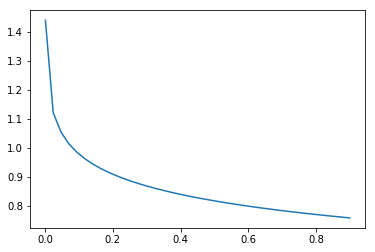

In [32]:
X=np.linspace(1e-3,0.9,40)
py.plot(X,0.8 + 0.1*np.log(.6/X))

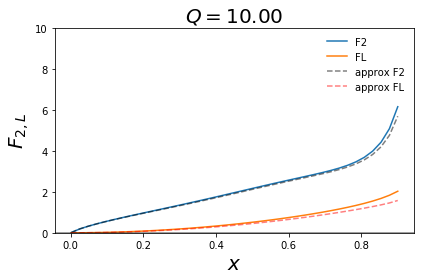

In [33]:
ncols,nrows=1,1
fig = py.figure(figsize=(ncols*6,nrows*4))
ax = fig.add_subplot(111)
ax.plot(X,F2,label='F2')
ax.plot(X,R*F2-2*XN*F1,label='FL')
ax.plot(X,aF2,'k--',label='approx F2',alpha=0.5)
ax.plot(X,aF2-2*X*aF1,'r--',label='approx FL',alpha=0.5)
ax.set_title(r'$Q=%0.2f$'%(Q),size=20)
ax.legend(fontsize=10,frameon=0)
ax.axhline(0,color='k',alpha=0.5)
#ax.set_xlim(0,kTmax)
ax.set_ylabel('$F_{2,L}$',size=20)
ax.set_xlabel('$x$',size=20)
#ax.semilogx()
ax.set_ylim(0,10)
py.tight_layout();
py.savefig('F1L-X.png')
py.show();

In [34]:
def update(Q=2,mq=0.3,ms=0.8,M=0.938):

    kTmin=0.001 # to avoid numerical errors
    X=np.linspace(1e-3,0.92,40)

    get_ms=lambda x: 0.8 + 0.1*np.log(.6/x)
    
    XN=np.array([lxn(x,M,Q) for x in X])
    F1=np.array([quad(lambda kT: kT*lF1(lxn(xbj,M,Q),Q,mq,get_ms(xbj),M,kT),kTmin,lkTmax(xbj,Q,mq,get_ms(xbj),M) )[0] for xbj in X])
    F2=np.array([quad(lambda kT: kT*lF2(lxn(xbj,M,Q),Q,mq,get_ms(xbj),M,kT),kTmin,lkTmax(xbj,Q,mq,get_ms(xbj),M) )[0] for xbj in X])
    R=np.array([(1+lxn(x,M,Q)**2*M**2/Q**2)**2/(1-lxn(x,M,Q)**2*M**2/Q**2) for x in X])

    aF1=np.array([quad(lambda kT:dapprox1(xbj,Q,mq,get_ms(xbj),M,kT) ,kTmin,lkTmax(xbj,Q,mq,get_ms(xbj),M))[0] for xbj in X])
    aF2=np.array([quad(lambda kT:dapprox2(xbj,Q,mq,get_ms(xbj),M,kT) ,kTmin,lkTmax(xbj,Q,mq,get_ms(xbj),M))[0] for xbj in X])

    ncols,nrows=1,1
    fig = py.figure(figsize=(ncols*6,nrows*4))
    ax = fig.add_subplot(111)
    ax.plot(X,(R*F2-2*XN*F1)/F2,label='FL/F2')
    ax.plot(X,(aF2-2*X*aF1)/aF2,'r--',label='approx FL/F2',alpha=0.5)
    ax.set_title(r'$Q=%0.2f\;\;ms=%0.2f$'%(Q,ms),size=20)
    ax.legend(fontsize=10,frameon=0)
    #ax.axhline(0,color='k',alpha=0.5)
    #ax.set_xlim(0,kTmax)
    ax.set_ylabel('$F_L/F_2$',size=20)
    ax.set_xlabel('$x$',size=20)
    #ax.semilogx()
    py.tight_layout();
    py.savefig('FLoF2-X.png')
    py.show();


interact(update,Q=(0,100,0.01),mq=(0,1,0.01),ms=(0,10,0.1),M=(0,10,0.1));